# Fraud Transaction Analysis
Analysis of fraud patterns in transaction data with key visualizations

 ## Load and Prepare Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os


warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

def load_and_prepare_data(file_path):
    """Load and prepare transaction data for analysis"""
    df = pd.read_csv(file_path)

    # Convert amount column to numeric
    df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)

    # Convert dates
    df['Post Date'] = pd.to_datetime(df['Post Date'], errors='coerce')
    df['Account Open Date'] = pd.to_datetime(df['Account Open Date'], errors='coerce')

    # Create fraud indicator
    df['Is_Fraud'] = df['Fraud Adjustment Indicator'].notna() & (df['Fraud Adjustment Indicator'].str.strip() != '')

    # Clean IDs
    df['Member ID'] = df['Member ID'].astype(str).str.lstrip('0')
    df['Account ID'] = df['Account ID'].astype(str).str.lstrip('0')

    # Basic statistics
    total_transactions = len(df)
    fraud_cases = df['Is_Fraud'].sum()
    fraud_rate = fraud_cases / total_transactions * 100

    print(f"Dataset Overview:")
    print(f"- Total transactions: {total_transactions:,}")
    print(f"- Fraud cases: {fraud_cases:,}")
    print(f"- Fraud rate: {fraud_rate:.4f}%")
    print(f"- Date range: {df['Post Date'].min().strftime('%Y-%m-%d')} to {df['Post Date'].max().strftime('%Y-%m-%d')}")
    print(f"- Unique accounts: {df['Account ID'].nunique():,}")
    print(f"- Unique members: {df['Member ID'].nunique():,}")

    return df

# Load data
file_path_1 = '../../data/raw/transaction_data.csv'
file_path_2 = '../../data/raw/Transaction Data 09232025.csv'
df1 = load_and_prepare_data(file_path_1)
df2 = load_and_prepare_data(file_path_2)

df_combined = pd.concat([df1, df2], ignore_index=True)
df_combined.drop_duplicates(inplace=True)

output_path = "../data/processed/transaction_data_merged.csv"
df_combined.to_csv(output_path, index=False)

# Display basic info
print(f"\nDataset shape: {df_combined.shape}")
display(df_combined.head())

Dataset Overview:
- Total transactions: 604,432
- Fraud cases: 378
- Fraud rate: 0.0625%
- Date range: 2024-09-01 to 2025-09-01
- Unique accounts: 1,953
- Unique members: 1,952
Dataset Overview:
- Total transactions: 579,672
- Fraud cases: 394
- Fraud rate: 0.0680%
- Date range: 2024-09-01 to 2025-09-01
- Unique accounts: 1,983
- Unique members: 1,981

Dataset shape: (1134963, 14)


,Account ID,Member ID,Account Type,Account Open Date,Member Age,Product ID,Post Date,Post Time,Amount,Action Type,Source Type,Transaction Description,Fraud Adjustment Indicator,Is_Fraud
0,6190877696,15336793,General Membership,2007-12-15,46,0007,2024-09-01,35,24.37,Withdrawal,Signature,APPLE.COM/BILL,NaN,False
1,8892002798,878709545,General Membership,2023-05-22,28,0007,2024-09-01,45,5.68,Withdrawal,Signature,LOVE'S #0679 INSIDE,NaN,False
2,8015188961,576034980,General Membership,2021-07-28,60,0007,2024-09-01,51,55.00,Withdrawal,Signature,CASH APP*ANITA,NaN,False
3,2272989105,210401436,General Membership,2006-04-05,54,0007,2024-09-01,110,5.00,Withdrawal,Online Banking,Transfer To *1775,NaN,False
4,7798496057,929194557,General Membership,2021-08-16,44,0007,2024-09-01,132,318.76,Withdrawal,Signature,AMAZON MKTPL*RK6Y33M30,NaN,False


In [ ]:
import pandas as pd
import numpy as np

merged_file = "../data/processed/transaction_data_merged.csv"
cleaned_file = "../../data/processed/transaction_data_cleaned.csv"

# Read Data
df = pd.read_csv(merged_file)

missing_tbl = (
    df.isna().sum().rename('missing_count').to_frame()
)
missing_tbl['missing_pct'] = (missing_tbl['missing_count'] / len(df) * 100).round(2)
print("\nMissing overview BEFORE cleaning:")
print(
    missing_tbl[missing_tbl['missing_count'] > 0]
      .sort_values('missing_count', ascending=False)
      .head(30)
)


# Amount Missing
df['Amount_missing'] = df['Amount'].isna()
amount_mean = df['Amount'].mean(skipna=True)
df['Amount'] = df['Amount'].fillna(amount_mean)

# Type Missing
for col in ['Type', 'Product ID', 'Action Type', 'Transaction Description']:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")


# Age == 0 
if 'Member Age' in df.columns:
    age_zero_count = (df['Member Age'] == 0).sum()
    print(f"Age==0 numbers: {age_zero_count}")

    # Fix by mean
    age_median = df.loc[df['Member Age'] > 0, 'Member Age'].median()
    df.loc[df['Member Age'] == 0, 'Member Age'] = age_median

# Outliers
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

def filter_outliers(row):
    if row['Is_Fraud']:  # fraud data keep
        return True
    # common data → check if in the field
    return (lower_bound <= row['Amount'] <= upper_bound)

df = df[df.apply(filter_outliers, axis=1)]


df.to_csv(cleaned_file, index=False)
print(f"Cleaned data saved to: {cleaned_file}")
print(f"Final dataset shape: {df.shape}")
display(df.head())



Missing overview BEFORE cleaning:
                            missing_count  missing_pct
Fraud Adjustment Indicator        1134484        99.96
Source Type                         29571         2.61
Transaction Description             24806         2.19
Amount                                 78         0.01
Action Type                            58         0.01
Product ID                             20         0.00
Age==0 numbers: 33004
 ../data/raw/transaction_data_cleaned.csv
(969939, 15)


,Account ID,Member ID,Account Type,Account Open Date,Member Age,Product ID,Post Date,Post Time,Amount,Action Type,Source Type,Transaction Description,Fraud Adjustment Indicator,Is_Fraud,Amount_missing
0,6190877696,15336793,General Membership,2007-12-15,46,0007,2024-09-01,35,24.37,Withdrawal,Signature,APPLE.COM/BILL,NaN,False,False
1,8892002798,878709545,General Membership,2023-05-22,28,0007,2024-09-01,45,5.68,Withdrawal,Signature,LOVE'S #0679 INSIDE,NaN,False,False
2,8015188961,576034980,General Membership,2021-07-28,60,0007,2024-09-01,51,55.00,Withdrawal,Signature,CASH APP*ANITA,NaN,False,False
3,2272989105,210401436,General Membership,2006-04-05,54,0007,2024-09-01,110,5.00,Withdrawal,Online Banking,Transfer To *1775,NaN,False,False
5,5757768331,100786009,LLC,2022-01-11,49,0007,2024-09-01,135,40.00,Withdrawal,Online Banking,Zelle DANIEL,NaN,False,False



=== Data Cleaning Validation ===
Missing values after cleaning:
Account ID                         0
Member ID                          0
Account Type                       0
Account Open Date                  0
Member Age                         0
Product ID                         0
Post Date                          0
Post Time                          0
Amount                             0
Action Type                        0
Source Type                    21143
Transaction Description            0
Fraud Adjustment Indicator    969460
Is_Fraud                           0
Amount_missing                     0
dtype: int64
Remaining Age==0 count: 0
Fraud rows removed during cleaning: 0


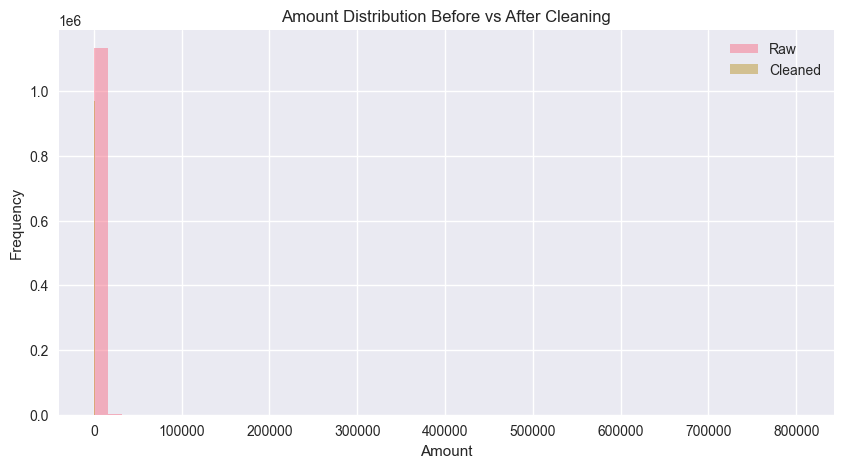

In [6]:
print("\n=== Data Cleaning Validation ===")

print("Missing values after cleaning:")
print(df.isna().sum())

if 'Member Age' in df.columns:
    print(f"Remaining Age==0 count: {(df['Member Age'] == 0).sum()}")

df_raw = pd.read_csv(merged_file)
fraud_removed = df_raw[df_raw['Is_Fraud'] & ~df_raw.index.isin(df.index)]
print(f"Fraud rows removed during cleaning: {len(fraud_removed)}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df_raw['Amount'].hist(alpha=0.5, bins=50, label='Raw')
df['Amount'].hist(alpha=0.5, bins=50, label='Cleaned')
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title("Amount Distribution Before vs After Cleaning")
plt.legend()
plt.show()


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

raw = pd.read_csv(merged_file)

# 
missing_counts = raw.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
total_rows = len(raw)
missing_pct = (missing_counts / total_rows * 100)

#
plt.figure(figsize=(10, max(4, 0.35*len(missing_pct))))
plt.barh(missing_pct.index[::-1], missing_pct.values[::-1])
for y, v in enumerate(missing_pct.values[::-1]):
    plt.text(v + 0.2, y, f'{v:.2f}%', va='center')
plt.xlabel('Missing percentage (%)')
plt.title('Missing values per column (all)')
plt.tight_layout()
plt.show()

# 
pie_series = missing_pct.drop('Fraud Adjustment Indicator', errors='ignore')

if not pie_series.empty:
    # combine 1%
    small_mask = pie_series < 1
    other_sum = pie_series[small_mask].sum()
    pie_series = pie_series[~small_mask]
    if other_sum > 0:
        pie_series.loc['Other (<1%)'] = other_sum

    plt.figure(figsize=(8,8))
    wedges, _, autotexts = plt.pie(
        pie_series.values,
        labels=None,      
        startangle=90,
        autopct=lambda p: f'{p:.2f}%' if p >= 1 else ''
    )
    plt.legend(
        wedges,
        [f'{k}' for k in pie_series.index],
        title='Columns',
        loc='center left',
        bbox_to_anchor=(1.0, 0.5)
    )
    plt.title('Missing value breakdown (excluding dominant column)')
    plt.tight_layout()
    plt.show()
else:
    print("No columns to plot in the pie chart after excluding the dominant column.")





FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/transaction_data_merged.csv'

In [35]:
# Compact Fraud Matching Algorithm
import pandas as pd
import numpy as np
import os
import re
from datetime import timedelta
from difflib import SequenceMatcher

def extract_date_merchant(description, adj_date):
    """Extract date and merchant information from fraud adjustment description"""
    if pd.isna(description): return None, None
    desc = str(description).upper()
    
    # Extract date pattern
    date_match = re.search(r'(\d{1,2}/\d{1,2})', desc)
    extracted_date = None
    if date_match:
        try:
            month, day = map(int, date_match.group(1).split('/'))
            year = adj_date.year - 1 if (month > adj_date.month or 
                (month == adj_date.month and day > adj_date.day)) else adj_date.year
            extracted_date = pd.Timestamp(year, month, day)
        except: pass
    
    # Extract merchant name
    clean_desc = re.sub(r'^(RTN|RETURN|UNAUTH|TRANS).*?|(RETURN|UNAUTH|TRANS).*$|\d{1,2}/\d{1,2}', '', desc).strip()
    merchant = clean_desc if clean_desc and len(clean_desc) > 2 else None
    
    return extracted_date, merchant

def similarity(a, b):
    """Calculate string similarity score"""
    if pd.isna(a) or pd.isna(b): return 0
    return SequenceMatcher(None, str(a).upper(), str(b).upper()).ratio()

def get_candidates(adj, txns, used_idx, date_filter=None, amount_filter='exact'):
    """Get candidate transactions based on filters"""
    fraud_amount, fraud_date = abs(adj['Amount']), adj['Post Date']
    filters = [~txns.index.isin(used_idx)]
    
    # Amount filter
    if amount_filter == 'window':
        start_date = fraud_date - timedelta(days=30)
        filters.extend([txns['Post Date'] >= start_date, txns['Post Date'] <= fraud_date])
    elif amount_filter == 'before':
        filters.append(txns['Post Date'] <= fraud_date)
    filters.append(abs(txns['Amount']) == fraud_amount)
    
    # Date filter
    if isinstance(date_filter, pd.Timestamp):
        filters.append(txns['Post Date'] == date_filter)
    elif date_filter == 'before':
        filters.append(txns['Post Date'] < fraud_date)
    elif date_filter == 'same_day_before':
        filters.extend([txns['Post Date'] == fraud_date, txns['Post Time'] < adj['Post Time']])
    
    return txns[np.logical_and.reduce(filters)]

def match_fraud_to_transaction(adj, txns, used_idx):
    """Multi-level fraud matching algorithm"""
    # Level 1: Exact match (Date + Amount + Merchant)
    extracted_date, merchant = extract_date_merchant(adj['Fraud Adjustment Indicator'], adj['Post Date'])
    if extracted_date and merchant:
        candidates = get_candidates(adj, txns, used_idx, extracted_date)
        if not candidates.empty:
            candidates['similarity'] = candidates['Transaction Description'].apply(lambda x: similarity(x, merchant))
            best = candidates.loc[candidates['similarity'].idxmax()]
            if best['similarity'] > 0.6:
                return best.name, 'exact_match'
    
    # Level 2: Date + Amount match
    if extracted_date:
        candidates = get_candidates(adj, txns, used_idx, extracted_date)
        if not candidates.empty:
            return candidates.iloc[0].name, 'date_amount_match'
    
    # Level 3: Time window + Amount match
    before_candidates = get_candidates(adj, txns, used_idx, 'before')
    if not before_candidates.empty:
        return before_candidates.loc[before_candidates['Post Date'].idxmax()].name, 'time_window_match'
    
    # Same day earlier time
    if 'Post Time' in txns.columns:
        same_day = get_candidates(adj, txns, used_idx, 'same_day_before')
        if not same_day.empty:
            return same_day.loc[same_day['Post Time'].idxmax()].name, 'time_window_match'
    
    # Level 4: Amount only match
    candidates = get_candidates(adj, txns, used_idx, amount_filter='before')
    if not candidates.empty:
        candidates['days_diff'] = (candidates['Post Date'].max() - candidates['Post Date']).dt.days
        return candidates.loc[candidates['days_diff'].idxmin()].name, 'amount_only_match'
    
    return None

def process_member_fraud(member_data, member_id, output_dir):
    """Process fraud matching for a single member"""
    df = member_data.copy()
    df['Post Date'] = pd.to_datetime(df['Post Date'])
    df['Is_Fraud'] = 0
    
    # Sort by time
    sort_cols = ['Post Date', 'Post Time'] if 'Post Time' in df.columns else ['Post Date']
    df = df.sort_values(sort_cols).reset_index(drop=True)
    
    # Find fraud adjustment records
    fraud_adjustments = df[df['Fraud Adjustment Indicator'].notna() & 
                          (df['Fraud Adjustment Indicator'].str.strip() != '')]
    
    # Initialize return values
    matched_count = 0
    total_adjustments = len(fraud_adjustments)
    
    if fraud_adjustments.empty:
        category = 'no_fraud'
    else:
        # Preprocessing checks
        if len(df) == 1 and not fraud_adjustments.empty:
            category = 'no_fraud'  # Single transaction that is an adjustment record
        else:
            # Check if all adjustments have no matching amounts
            no_match_count = 0
            for _, adj in fraud_adjustments.iterrows():
                fraud_amount = abs(adj['Amount'])
                other_txns = df[df.index != adj.name]
                if not (abs(other_txns['Amount']) == fraud_amount).any():
                    no_match_count += 1
            
            if no_match_count == len(fraud_adjustments):
                category = 'no_fraud'  # All adjustments have no matching amounts
            else:
                # Execute matching
                used_indices = set()
                successful_adjustments = []  # Track successfully matched adjustments
                
                for _, fraud_adj in fraud_adjustments.iterrows():
                    fraud_amount = abs(fraud_adj['Amount'])
                    other_txns = df[df.index != fraud_adj.name]
                    
                    # Skip adjustment if no matching amount exists
                    if not (abs(other_txns['Amount']) == fraud_amount).any():
                        continue
                    
                    match_result = match_fraud_to_transaction(fraud_adj, df, used_indices)
                    if match_result:
                        original_idx, match_type = match_result
                        df.loc[original_idx, 'Is_Fraud'] = 1
                        used_indices.add(original_idx)
                        matched_count += 1
                        successful_adjustments.append(fraud_adj.name)
                
                # Recalculate valid adjustments count (excluding those with no matching amounts)
                valid_adjustments = 0
                for _, adj in fraud_adjustments.iterrows():
                    fraud_amount = abs(adj['Amount'])
                    other_txns = df[df.index != adj.name]
                    if (abs(other_txns['Amount']) == fraud_amount).any():
                        valid_adjustments += 1
                
                # Determine category based on valid adjustments count
                if matched_count == valid_adjustments and matched_count > 0:
                    category = 'matched'
                elif matched_count > 0:
                    category = 'unmatched'
                else:
                    category = 'problematic'
                
                # Update total_adjustments to valid adjustments count
                total_adjustments = valid_adjustments
    
    # Save file
    subfolder_map = {'matched': 'fully_matched', 'unmatched': 'partially_matched', 
                     'problematic': 'problematic_cases', 'no_fraud': 'unmatched_cases'}
    category_dir = os.path.join(output_dir, subfolder_map[category])
    os.makedirs(category_dir, exist_ok=True)
    
    # Prepare output data with standardized column order
    output_columns = ['Account ID', 'Member ID', 'Account Type', 'Account Open Date', 
                     'Member Age', 'Product ID', 'Post Date', 'Post Time', 'Amount', 
                     'Action Type', 'Source Type', 'Transaction Description', 
                     'Fraud Adjustment Indicator', 'Is_Fraud']
    
    # Keep all records, do not remove any rows
    # Fraud Adjustment Indicator values remain unchanged
    output_data = df.copy()
    
    # Ensure all required columns exist and arrange in specified order
    for col in output_columns:
        if col not in output_data.columns:
            if col == 'Is_Fraud':
                output_data[col] = 0
            else:
                output_data[col] = None
    
    output_data = output_data[output_columns]
    
    filename = f"member_{member_id}.csv"
    output_path = os.path.join(category_dir, filename)
    output_data.to_csv(output_path, index=False)
    
    return category, matched_count, total_adjustments

def process_fraud_data_complete(input_csv_path, output_dir='../data/processed'):
    """Complete fraud data processing pipeline"""
    os.makedirs(output_dir, exist_ok=True)
    
    print("Loading transaction data...")
    df = pd.read_csv(input_csv_path, low_memory=False)
    print(f"Loaded {len(df):,} transactions")
    
    # Identify only fraud victim members (members with fraud indicators)
    fraud_victims = df[df['Fraud Adjustment Indicator'].notna() & 
                      (df['Fraud Adjustment Indicator'].str.strip() != '')]['Member ID'].unique()
    
    print(f"Found {len(fraud_victims)} fraud victim members")
    print("Note: Only members with fraud indicators will be processed and output")
    
    # Processing statistics
    counts = {'matched': 0, 'unmatched': 0, 'problematic': 0, 'no_fraud': 0}
    summary_results = []
    
    # Process only fraud victims
    print("\nProcessing fraud victims...")
    for i, member_id in enumerate(fraud_victims, 1):
        try:
            print(f"Processing member {member_id} ({i}/{len(fraud_victims)})")
            member_data = df[df['Member ID'] == member_id]
            category, matches_found, total_adjustments = process_member_fraud(member_data, member_id, output_dir)
            
            counts[category] += 1
            summary_results.append({
                'Member_ID': member_id, 'Category': category, 'Fraud_Found': matches_found,
                'Total_Adjustments': total_adjustments, 'Match_Rate': f"{matches_found}/{total_adjustments}",
                'All_Matched': matches_found == total_adjustments and matches_found > 0
            })
            
            print(f"  Result: {matches_found}/{total_adjustments} -> {category}")
        except Exception as e:
            print(f"  Error: {e}")
            counts['problematic'] += 1
    
    # Save summary report
    summary_df = pd.DataFrame(summary_results)
    summary_df.to_csv(os.path.join(output_dir, 'fraud_processing_summary.csv'), index=False)
    
    print(f"\n{'='*60}")
    print("Fraud data processing completed!")
    print(f"{'='*60}")
    print(f"Total fraud victim members processed: {len(fraud_victims):,}")
    print(f"Fully matched: {counts['matched']:,}")
    print(f"Partially matched: {counts['unmatched']:,}")
    print(f"Problematic: {counts['problematic']:,}")
    print(f"Unmatched cases (after processing): {counts['no_fraud']:,}")
    print(f"\nResults saved to: {output_dir}")
    
    return len(fraud_victims), counts

# Usage example
if __name__ == "__main__":
    print("Starting fraud data processing...")
    input_file = '../../data/processed/transaction_data_cleaned.csv'
    output_dir = '../../data/processed'
    
    total_members, counts = process_fraud_data_complete(input_file, output_dir)
    
    print(f"\nProcessing completed! Total members: {total_members:,}")
    print("📁 Output folders: fully_matched, partially_matched, problematic_cases, unmatched_cases")

print("Compact fraud matching algorithm loaded!")

Starting fraud data processing...
Loading transaction data...
Loaded 969,939 transactions
Found 204 fraud victim members
Note: Only members with fraud indicators will be processed and output

Processing fraud victims...
Processing member 81908447 (1/204)
  Result: 2/2 -> matched
Processing member 109702802 (2/204)
  Result: 0/2 -> no_fraud
Processing member 578759845 (3/204)
  Result: 1/1 -> matched
Processing member 871450422 (4/204)
  Result: 5/5 -> matched
Processing member 221834549 (5/204)
  Result: 1/1 -> matched
Processing member 25795200 (6/204)
  Result: 4/4 -> matched
Processing member 697196787 (7/204)
  Result: 2/2 -> matched
Processing member 98863673 (8/204)
  Result: 2/2 -> matched
Processing member 424821761 (9/204)
  Result: 1/1 -> matched
Processing member 38616906 (10/204)
  Result: 0/1 -> no_fraud
Processing member 981630569 (11/204)
  Result: 4/4 -> matched
Processing member 542179322 (12/204)
  Result: 1/1 -> matched
Processing member 841102515 (13/204)
  Result: 